In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
client = pd.read_csv('data/x5-uplift-valid/data/clients2.csv')

In [3]:
products = pd.read_csv('data/x5-uplift-valid/data/products.csv')

In [4]:
train_purch = pd.read_csv('data/x5-uplift-valid/train_purch/train_purch.csv')
test_purch = pd.read_csv('data/x5-uplift-valid/test_purch/test_purch.csv')

In [5]:
train_purch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


## EDA

### Client

In [6]:
client.head()

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [7]:
client.shape

(200039, 6)

In [8]:
client.describe()

,client_id.1,age
count,0.0,200039.000000
mean,NaN,46.417329
std,NaN,49.532475
min,NaN,-7491.000000
25%,NaN,34.000000
50%,NaN,45.000000
75%,NaN,59.000000
max,NaN,1852.000000


In [9]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          200039 non-null  object 
 1   client_id.1        0 non-null       float64
 2   first_issue_date   200039 non-null  object 
 3   first_redeem_date  182493 non-null  object 
 4   age                200039 non-null  int64  
 5   gender             200039 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ MB


In [10]:
# Признак client_id.1 не содержит данных, удалим его
client.drop(columns='client_id.1', inplace=True)

In [11]:
# Посмотрим количество строк с ошибочным возрастом
client[(client['age'] > 90) | (client['age'] < 10)]['age'].shape

(749,)

In [12]:
#Заменим ошибочный возраст
client.loc[(client['age'] > 90) | (client['age'] < 10), 'age'] = 45

In [13]:
client['client_id_dec'] = client['client_id'].apply(lambda x: int(x, 16))

In [14]:
client['first_redeem_date'] = client['first_redeem_date'].astype("datetime64[ns]", copy=True)

<AxesSubplot:xlabel='gender', ylabel='Count'>

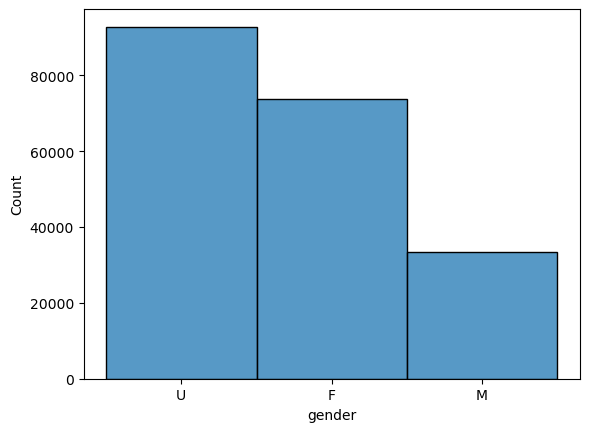

In [15]:
sns.histplot(client['gender'])

In [16]:
client['first_redeem_date'] = (pd.to_datetime(client['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
client['first_issue_date'] = (pd.to_datetime(client['first_issue_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

In [17]:
client

,client_id,first_issue_date,first_redeem_date,age,gender,client_id_dec
0,000012768d,1501947648,1.515094e+09,45,U,1209997
1,000036f903,1491832463,1.492951e+09,72,F,3602691
2,00010925a5,1532449289,1.536942e+09,83,U,17376677
3,0001f552b0,1498850438,1.535461e+09,33,F,32854704
4,00020e7b18,1511782905,1.515607e+09,73,U,34503448
...,...,...,...,...,...,...
200034,fffe0abb97,1511773014,1.518341e+09,35,F,1099478776727
200035,fffe0ed719,1505465604,1.513090e+09,69,U,1099479045913
200036,fffea1204c,1517417977,1.520874e+09,73,F,1099488632908
200037,fffeca6d22,1514462173,NaN,77,F,1099491339554


### Products

In [18]:
train_purch = train_purch.merge(products[['product_id', 'netto', 'is_own_trademark', 'is_alcohol']], how='left', on='product_id')
test_purch = test_purch.merge(products[['product_id', 'netto', 'is_own_trademark', 'is_alcohol']], how='left', on='product_id')

In [19]:
products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [20]:
for i in ['segment_id', 'brand_id', 'vendor_id']:
    print(i, products[i].nunique())

segment_id 116
brand_id 4296
vendor_id 3193


In [21]:
level_1 = products['level_1'].nunique()
level_2 = products['level_2'].nunique()
level_3 = products['level_3'].nunique()
level_4 = products['level_4'].nunique()

print(f'level_1: {level_1}\nlevel_2: {level_2}\nlevel_3: {level_3}\nlevel_4: {level_4}')


level_1: 3
level_2: 42
level_3: 201
level_4: 790


In [22]:
for i in products['level_1'].unique():
    print(i, ':')
    print('level_2:', products[products['level_1'] == i]['level_2'].nunique())
    print('level_3:', products[products['level_1'] == i]['level_3'].nunique())
    print('level_4:', products[products['level_1'] == i]['level_4'].nunique())

c3d3a8e8c6 :
level_2: 12
level_3: 47
level_4: 201
e344ab2e71 :
level_2: 11
level_3: 85
level_4: 356
ec62ce61e3 :
level_2: 19
level_3: 69
level_4: 233
nan :
level_2: 0
level_3: 0
level_4: 0


Судя по всему левелы - группы товаров, например 1 уровень - продукты питания, на 2 - бакалея, овощи, фрукты и т.д

In [23]:
products[products['is_alcohol']==1]['level_4'].nunique()

38

Группа товаров алгоколя левелы 1 и 2 относится к одному левелу, что подтверждает нашу теорию.

In [24]:
products[products['is_own_trademark'] == 1]['level_2'].nunique()


22

In [25]:
for i in products['segment_id'].unique():
    print(i, ':')
    print('level_1:', products[products['segment_id'] == i]['level_2'].nunique())
    print('level_2:', products[products['segment_id'] == i]['level_2'].nunique())
    print('level_3:', products[products['segment_id'] == i]['level_3'].nunique())
    print('level_4:', products[products['segment_id'] == i]['level_4'].nunique())

123.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 5
105.0 :
level_1: 3
level_2: 3
level_3: 7
level_4: 11
271.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 10
172.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 14
165.0 :
level_1: 1
level_2: 1
level_3: 3
level_4: 7
212.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 1
48.0 :
level_1: 2
level_2: 2
level_3: 2
level_4: 8
177.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 5
116.0 :
level_1: 1
level_2: 1
level_3: 2
level_4: 9
321.0 :
level_1: 1
level_2: 1
level_3: 4
level_4: 9
150.0 :
level_1: 3
level_2: 3
level_3: 4
level_4: 7
102.0 :
level_1: 2
level_2: 2
level_3: 7
level_4: 12
85.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 4
119.0 :
level_1: 1
level_2: 1
level_3: 3
level_4: 7
111.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 13
92.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 7
214.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 2
223.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 1
148.0 :
level_1: 2
level_2: 2
level_3: 10
level_4: 35
230.0 :


In [26]:
train_purch['transaction_datetime'] = (pd.to_datetime(train_purch['transaction_datetime']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
test_purch['transaction_datetime'] = (pd.to_datetime(test_purch['transaction_datetime']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

Оставим значимые признаки, которые все являются категориальными и закодируем их ванхотингом

In [27]:
#list for feature encoding products
list_feat_prod = ['level_4'] 
list_add_client = ['client_id', 'age', 'first_redeem_date', 'first_issue_date']

In [28]:
class client_products():
    def __init__(self, data, data_prod, list_feat_prod, n_components = 8):
        self.data = data
        self.data_prod = data_prod
        self.list_feat_prod = list_feat_prod
        self.n_components = n_components
        
    def one_hot(self):
        #Prepare products for one-hot encoding
        x = self.data_prod[self.list_feat_prod]
        x = x.to_numpy()
        x = x.reshape((-1, len(self.list_feat_prod)))
        
        #one hot encoding
        result_one = OneHotEncoder().fit_transform(x)
        return result_one.toarray()
    
    def PCA(self, x):
        pca = PCA(n_components=self.n_components)
        result_pca = pca.fit_transform(x)
        
        #transform to dataframe
        result_pca = pd.DataFrame(result_pca)
        result_pca['product_id'] = self.data_prod['product_id']
        return result_pca
        
    def prod_merge_client(self, x, multiply=True):
        result_prod = self.data[['client_id', 'product_id', 'product_quantity']].merge(x, how='left', on='product_id')
        
        # vectors * quantity
        s = [i for i in range(self.n_components)]
        if multiply == True:
            result_prod[s] =  pd.DataFrame(np.multiply(result_prod[s].to_numpy(), result_prod['product_quantity'].to_numpy().reshape(-1, 1)))
        
        #  delete unnecessary features
        result_prod.drop(['product_id', 'product_quantity'], axis=1, inplace=True)
        #transofrm names column to str 
        result_prod.columns = [str(i) for i in result_prod.columns.to_list()]
        return result_prod.groupby(by='client_id').sum()
    
    def add_feature(self, x):
        self.data['price'] = np.where(self.data['product_quantity']==0, 0, self.data['trn_sum_from_iss'] / self.data['product_quantity']) 
        col = ['client_id',
               'regular_points_received',
               'express_points_received',
               'regular_points_spent',
               'express_points_spent',
               'purchase_sum',
               'price',
               'netto',
                'is_own_trademark',
                'is_alcohol'
               ]
        mean_data = self.data[col].groupby(by='client_id',  as_index=False).mean()
        count_data = self.data[['client_id', 'transaction_id']].groupby(by='client_id',  as_index=False).count()
        first_buy = self.data[['client_id', 'transaction_datetime']].groupby(by='client_id').min()
        mean_data = mean_data.merge(count_data, how='left', on='client_id')
        mean_data = mean_data.merge(first_buy, how='left', on='client_id')
        result = x.merge(mean_data, how='left', on='client_id')      

        return result

    def sclaler(self, x):
        result_scaler = MinMaxScaler().fit_transform(x.iloc[:, 1:])
        columns = x.columns.to_list()[1:]
        x[columns] = pd.DataFrame(result_scaler)
        return x


In [29]:
a = client_products(train_purch, products, list_feat_prod)
one = a.one_hot()
pca = a.PCA(one)
prod_merge_client = a.prod_merge_client(pca)

In [30]:
a_seg = client_products(train_purch, products, ['segment_id'])
one_seg = a_seg.one_hot()
one_seg = pd.DataFrame(one_seg)
one_seg['product_id'] = products['product_id']
prod_merge_client_seg = a_seg.prod_merge_client(one_seg)

In [31]:
prod_merge_client = prod_merge_client.merge(prod_merge_client_seg, how='left', on='client_id')

In [32]:
res = a.add_feature(prod_merge_client)

In [33]:
res

,client_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,price,netto,is_own_trademark,is_alcohol,transaction_id,transaction_datetime
0,000012768d,0.355781,-1.312780,-1.804815,-1.323690,-1.469317,0.210510,1.044833,-0.833008,4.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.551923,0.000000,0.000000,0.000000,784.788462,46.403846,0.540231,0.076923,0.000000,52,1543648365
1,000036f903,10.003428,-0.463047,3.784692,-1.123606,-1.832560,-0.611661,-1.616685,-0.550288,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,1.0,15.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,34.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0,2.0,0.0,13.0,0.0,1.0,0.0,3.0,2.150000,2.222222,0.000000,0.000000,362.746914,50.374486,0.481877,0.086420,0.006173,162,1543402116
2,0001f552b0,-3.779058,-3.192809,-3.454585,-2.215659,0.629662,-0.158581,-0.882117,-0.799215,1.0,3.0,0.0,5.0,0.0,4.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,3.0,0.0,2.0,6.420930,0.000000,0.000000,0.000000,557.841163,60.972481,0.483849,0.116279,0.000000,86,1543043683
3,00020e7b18,-10.359120,-22.526962,4.227034,-0.014116,-8.232325,0.918253,-5.457034,-9.747162,39.0,1.0,0.0,3.0,0.0,3.0,24.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0,1.0,0.0,8.0,36.0,9.0,7.0,1.0,0.0,5.0,0.0,0.0,10.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,0.0,6.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,6.0,0.0,3.0,0.0,1.0,0.0,0.0,14.0,0.0,2.0,1.0,0.0,0.0,8.0,0.0,10.0,6.0,0.0,0.0,8.0,0.0,7.0,22.382353,0.000000,-9.830882,-1.213235,2055.038456,62.344056,0.482176,0.161765,0.000000,272,1542961286
4,000220a0a7,-6.280739,-5.320772,-4.380316,-6.214154,-1.817169,-4.074261,-1.938217,-1.907696,0.0,1.0,1.0,1.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,2.0,0.0,0.0,3.0,10.548235,0.000000,0.000000,0.000000,817.500941,66.485294,0.357918,0.188235,0.011765,85,1544547256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [34]:
result = res.merge(client[list_add_client], how='left', on='client_id')

In [35]:
result

,client_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,price,netto,is_own_trademark,is_alcohol,transaction_id,transaction_datetime,age,first_redeem_date,first_issue_date
0,000012768d,0.355781,-1.312780,-1.804815,-1.323690,-1.469317,0.210510,1.044833,-0.833008,4.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.551923,0.000000,0.000000,0.000000,784.788462,46.403846,0.540231,0.076923,0.000000,52,1543648365,45,1.515094e+09,1501947648
1,000036f903,10.003428,-0.463047,3.784692,-1.123606,-1.832560,-0.611661,-1.616685,-0.550288,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,1.0,15.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,34.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0,2.0,0.0,13.0,0.0,1.0,0.0,3.0,2.150000,2.222222,0.000000,0.000000,362.746914,50.374486,0.481877,0.086420,0.006173,162,1543402116,72,1.492951e+09,1491832463
2,0001f552b0,-3.779058,-3.192809,-3.454585,-2.215659,0.629662,-0.158581,-0.882117,-0.799215,1.0,3.0,0.0,5.0,0.0,4.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,3.0,0.0,2.0,6.420930,0.000000,0.000000,0.000000,557.841163,60.972481,0.483849,0.116279,0.000000,86,1543043683,33,1.535461e+09,1498850438
3,00020e7b18,-10.359120,-22.526962,4.227034,-0.014116,-8.232325,0.918253,-5.457034,-9.747162,39.0,1.0,0.0,3.0,0.0,3.0,24.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0,1.0,0.0,8.0,36.0,9.0,7.0,1.0,0.0,5.0,0.0,0.0,10.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,0.0,6.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,6.0,0.0,3.0,0.0,1.0,0.0,0.0,14.0,0.0,2.0,1.0,0.0,0.0,8.0,0.0,10.0,6.0,0.0,0.0,8.0,0.0,7.0,22.382353,0.000000,-9.830882,-1.213235,2055.038456,62.344056,0.482176,0.161765,0.000000,272,1542961286,73,1.515607e+09,1511782905
4,000220a0a7,-6.280739,-5.320772,-4.380316,-6.214154,-1.817169,-4.074261,-1.938217,-1.907696,0.0,1.0,1.0,1.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,2.0,0.0,0.0,3.0,10.548235,0.000000,0.000000,0.000000,817.500941,6

In [36]:
result.to_csv('client_train.csv', index=False)

In [37]:
b = client_products(test_purch, products, list_feat_prod)

In [38]:
one = b.one_hot()
pca = b.PCA(one)
prod_merge_client = b.prod_merge_client(pca)

In [39]:
b_seg = client_products(test_purch, products, ['segment_id'],  n_components = 5)
one_seg = b_seg.one_hot()
one_seg = pd.DataFrame(one_seg)
one_seg['product_id'] = products['product_id']
prod_merge_client_seg = b_seg.prod_merge_client(one_seg)

In [40]:
prod_merge_client = prod_merge_client.merge(prod_merge_client_seg, how='left', on='client_id')

In [41]:
res = b.add_feature(prod_merge_client)
result_test = res.merge(client[list_add_client], how='left', on='client_id')

In [42]:
result_test

,client_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,price,netto,is_own_trademark,is_alcohol,transaction_id,transaction_datetime,age,first_redeem_date,first_issue_date
0,00010925a5,-3.286651,-4.191003,-0.528918,-2.925622,-1.575245,-0.063147,1.081676,-0.415735,2.0,5.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,4.0,1.0,0.0,1.0,3.0,2.089744,0.0,-1.089744,0.000000,365.307692,68.089744,0.615551,0.115385,0.012821,78,1543143378,83,1.536942e+09,1532449289
1,00035a21d9,-0.951189,-1.185884,-0.748372,-1.057212,-0.293547,-0.741212,0.509296,-0.439351,0.0,2.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,9.969231,0.0,-4.000000,-15.000000,674.827692,59.307692,0.419346,0.038462,0.000000,26,1549712782,69,1.551540e+09,1549723582
2,00038f9200,-11.146938,8.943293,-4.434049,-5.536691,-6.127315,6.039925,0.222843,-2.613397,11.0,4.0,2.0,5.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,5.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,0.0,0.0,4.0,0.0,1.0,3.0,0.0,3.0,0.0,1.0,0.0,5.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,6.0,0.0,4.0,2.225949,0.0,-0.550633,0.000000,238.506329,44.438819,0.546804,0.088608,0.000000,158,1544180630,79,1.547301e+09,1544191430
3,0004315e57,-5.125624,-6.295154,-3.827619,-5.275782,-1.170564,-2.692296,-1.652692,-1.830870,1.0,0.0,0.0,7.0,0.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,12.0,0.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,2.0,4.0,1.0,3.0,2.0,0.0,1.0,0.0,6.0,6.261475,0.0,-3.057377,-4.672131,667.672131,51.953552,0.366172,0.180328,0.000000,122,1543152056,38,1.549120e+09,1543162856
4,0006fca4bf,-1.698256,-2.092594,-1.285078,-1.785885,-0.798678,-0.008321,-0.604449,0.539743,1.0,0.0,0.0,0.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.978571,0.0,0.000000,0.000000,1799.678571,66.211905,0.445714,0.14285

In [43]:
result_test.to_csv('client_test.csv', index=False)

In [ ]:
#s = client_products(train_purch, products, list_feat_prod)

In [ ]:
#list_feat_prod

In [ ]:
#products.head()